# L4b: One versus the Rest Strategy for Multi-class Classification
In this lab, we implement the One versus the Rest (OvR) strategy, which extends binary logistic regression to multi-class problems by training one classifier per class. Each classifier learns to distinguish its assigned class from all others. OvR is computationally efficient and interpretable: rather than learning a complex multinomial model, we leverage multiple simple binary classifiers.

> __Learning Objectives:__
> 
> By the end of this lab, you will be able to:
> 
> * __Construct OvR datasets from MNIST:__ Convert one-hot labels into binary $\pm 1$ labels for each digit and create balanced training/testing datasets.
> * __Train one logistic regression model per class:__ Implement the OvR training loop and store a dictionary of trained binary classifiers.
> * __Evaluate OvR performance with confusion matrices:__ Compute and interpret confusion matrices for a selected digit vs. the rest.

Let's get started!
___


## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.

### Constants
We define constants that control data loading, image dimensions, and the train/test split. The `number_of_examples::Int` constant sets how many images per digit to load from MNIST, while `number_of_test_examples::Int` reserves a portion for evaluation. The remaining constants specify the image geometry.

In [2]:
number_of_examples = 3000; # how many training examples of *each* number to include from the library
number_of_test_examples = 500; # how many examples are we going to test on?
number_of_training_examples = number_of_examples - number_of_test_examples; # how many training examples of *each* number to include from the library
number_digit_array = range(0,length=10,step=1) |> collect; # numbers 0 ... 9
number_of_rows = 28; # number of rows in the image
number_of_cols = 28; # number of cols in the image
number_of_pixels = number_of_rows*number_of_cols; # how many pixels do we have in the image?

### Data
Our data consists of images of handwritten digits (0–9) from the [Modified National Institute of Standards and Technology (MNIST) database](https://en.wikipedia.org/wiki/MNIST_database). 

We build a training dataset to estimate model parameters, stored in the `training_image_dataset::Vector{Tuple{Vector{Float64}, OneHotVector{UInt32}}}` variable, and a test dataset to evaluate generalization to unseen data, stored in the `testing_image_dataset::Vector{Tuple{Vector{Float64}, OneHotVector{UInt32}}}` variable.

> __Data format:__ The first element of each tuple is the input data $\mathbf{x}$ (the image pixels arranged as a vector), and the second element is the label (whether the image corresponds to digits 0–9).
>
> __Type considerations:__ The input data uses `Float64` precision for numerical stability in gradient-based optimization. The labels are [one-hot encoded](https://en.wikipedia.org/wiki/One-hot), and the input data is stored as a vector rather than a matrix (even though the original image is a $28\times 28$ matrix of grayscale values).

We load `number_of_examples::Int` images per digit into the `digits_image_dictionary::Dict{Int, Array{N0f8,3}}` dictionary, where each key is a digit (0–9) and each value is a 3D array of grayscale images. We then convert these to vector format by linearizing the $28\times 28$ matrix of grayscale values into a vector of 784 pixels.

In [3]:
digits_image_dictionary = MyMNISTHandwrittenDigitImageDataset(number_of_examples = number_of_examples);

Let's inspect the `digits_image_dictionary::Dict{Int, Array{N0f8,3}}` variable. Each entry maps a digit to a $28\times 28\times n$ array, where $n$ is the number of images for that digit. We can index into the array to view individual images:

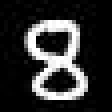

In [4]:
digits_image_dictionary[8][ :, :, 10] # how does the indexing work? This is the 10th example of the digit "8"

Next, let's partition the `digits_image_dictionary::Dict{Int, Array{N0f8,3}}` into training and testing datasets. We randomly select `number_of_training_examples::Int` images per digit for training, and the remaining images are used for testing. In each case, we convert the $28\times 28$ images into vector format by linearizing the matrix into a vector of 784 pixels.

Let's start with the training dataset. 

> __What is vectorization?__ Each $N\times N$ image array containing grayscale values at each pixel is converted to an $N^{2}$ vector by concatenating pixel values. The image class (the digit it represents) is converted to [one-hot format](https://en.wikipedia.org/wiki/One-hot). 

Let's save the training data in the `training_image_dataset::Vector{Tuple{Vector{Float64}, OneHotVector{UInt32}}}` variable.


In [5]:
training_image_dataset = let

    # initialize -
    training_image_dataset = Vector{Tuple{Vector{Float64}, OneHotVector{UInt32}}}();
    for i ∈ number_digit_array
        Y = onehot(i, number_digit_array); # what image class is this?
        X = digits_image_dictionary[i]; # this gets ALL images of digit "i"

        for t ∈ 1:number_of_training_examples
            D = reshape(transpose(X[:,:,t]) |> Matrix, number_of_pixels) |> vec; # flatten
            training_tuple = (D,Y); # create training tuple (image data, image class)
            push!(training_image_dataset,training_tuple);
        end
    end
    training_image_dataset; # return
end


25000-element Vector{Tuple{Vector{Float64}, OneHotVector{UInt32}}}:
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03137254901960784, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00784313725490196, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03529411764705882  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00784313725490196  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01568627450980392  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
 ([0.0, 0.0, 0.0, 

Next, we load `number_of_test_examples::Int` images from the `digits_image_dictionary::Dict{Int, Array{N0f8,3}}` for testing purposes. We save the test data in the `testing_image_dataset::Vector{Tuple{Vector{Float64}, OneHotVector{UInt32}}}` variable.


In [6]:
testing_image_dataset = let
    
    # initialize -
    testing_image_dataset = Vector{Tuple{Vector{Float64}, OneHotVector{UInt32}}}()
    
    # main -
    for i ∈ number_digit_array
        Y = onehot(i, number_digit_array); # what image class is this?
        X = digits_image_dictionary[i]; # this gets ALL images of digit "i"
        
        for t ∈ (number_of_training_examples+1):number_of_examples

            D = reshape(transpose(X[:,:,t]) |> Matrix, number_of_pixels) |> vec; # flatten
            testing_tuple = (D,Y); # create testing tuple (image data, image class)
            push!(testing_image_dataset, testing_tuple);
        end
    end

    testing_image_dataset; # return
end;


### Implementation
Before constructing the OvR datasets, we define three helper functions that will be used across all tasks:

> __Helper functions:__
>
> * `downsample_image(x::Vector{Float64}, pool::Int)::Vector{Float64}` reduces a 784-pixel image vector to a smaller feature vector by average pooling over non-overlapping $\text{pool}\times\text{pool}$ blocks.
> * `build_ovr_dataset(...)` takes the full image dataset and a target digit, then constructs a balanced binary dataset with $\pm 1$ labels and downsampled features.
> * `ovr_confusion_for_digit(digit::Int; ...)` evaluates a trained OvR classifier on test data and returns the confusion matrix, accuracy, predictions, true labels, and class probabilities.

Let's define these functions:

In [ ]:
function downsample_image(x::Vector{Float64}, pool::Int)::Vector{Float64}

    # undo the earlier transpose used during vectorization
    img = reshape(x, (number_of_cols, number_of_rows))';
    new_rows = number_of_rows ÷ pool;
    new_cols = number_of_cols ÷ pool;
    pooled = zeros(Float64, new_rows, new_cols);

    for i ∈ 1:new_rows
        for j ∈ 1:new_cols
            r = (pool*(i-1)+1):(pool*i);
            c = (pool*(j-1)+1):(pool*j);
            pooled[i,j] = mean(img[r,c]);
        end
    end

    return vec(pooled);
end;

function build_ovr_dataset(image_dataset::Vector{Tuple{Vector{Float64}, OneHotVector{UInt32}}},
    digit::Int; number_positive::Int = 200, number_negative::Int = 200, pool::Int = 4)

    # collect indices for positive/negative classes
    pos_idx = Int[];
    neg_idx = Int[];
    for (i,(x,y_onehot)) ∈ enumerate(image_dataset)
        label = number_digit_array[argmax(y_onehot)];
        if (label == digit)
            push!(pos_idx, i);
        else
            push!(neg_idx, i);
        end
    end

    # sample a balanced subset
    pos_sel = pos_idx[randperm(length(pos_idx))[1:number_positive]];
    neg_sel = neg_idx[randperm(length(neg_idx))[1:number_negative]];
    selected = vcat(pos_sel, neg_sel);
    selected = selected[randperm(length(selected))];

    # allocate feature matrix and label vector
    features_per_image = (number_of_rows ÷ pool) * (number_of_cols ÷ pool);
    X = Array{Float64,2}(undef, length(selected), features_per_image);
    y = Array{Int64,1}(undef, length(selected));

    for (k, idx) ∈ enumerate(selected)
        x, y_onehot = image_dataset[idx];
        X[k,:] = downsample_image(x, pool);
        label = number_digit_array[argmax(y_onehot)];
        y[k] = (label == digit) ? 1 : -1;
    end

    return X, y;
end;

function ovr_confusion_for_digit(digit::Int;
    dataset::Dict = ovr_testing_dataset,
    models::Dict = ovr_model_dictionary)

    @assert haskey(dataset, digit) "Digit $(digit) not found in test dataset."
    @assert haskey(models, digit) "Digit $(digit) not found in model dictionary."

    X_test, y_test = dataset[digit];
    number_of_examples = size(X_test,1);
    Xb = [X_test ones(number_of_examples)];
    model = models[digit];

    # compute class probabilities
    P = classify(Xb, model);

    # convert probabilities to ±1 labels
    ŷ = zeros(Int64, number_of_examples);
    for i ∈ 1:number_of_examples
        ŷ[i] = (P[i,1] ≥ P[i,2]) ? 1 : -1;
    end

    CM = confusion(y_test, ŷ);
    accuracy = (CM[1,1] + CM[2,2]) / length(y_test);

    return CM, accuracy, ŷ, y_test, P
end;

ovr_confusion_for_digit (generic function with 1 method)

___

## Task 1: Create the One versus the Rest (OvR) Dataset
In this task, we create one binary dataset per digit. For a chosen digit `k`, we set the label to `+1` when the image shows digit `k`, and to `-1` otherwise.

> __Implementation note__:
>
> The logistic regression learner in this package uses a finite-difference approximation of the gradient. This is computationally expensive for 784-pixel images. To keep the lab interactive, we:
>
> * Downsample each $28\times 28$ image into a $7\times 7$ average-pooled image (49 features).
> * Build a balanced dataset with a small number of positive and negative examples per digit.

We store the results in two dictionaries: `ovr_training_dataset` and `ovr_testing_dataset`. Each dictionary maps a digit to a tuple `(X, y)` where `X` is the feature matrix and `y` is the $\pm 1$ label vector. These balanced datasets are the foundation for training individual classifiers in Task 2.


In [8]:
ovr_training_dataset, ovr_testing_dataset = let

    # initialize -
    training_dict = Dict{Int, Tuple{Array{Float64,2}, Vector{Int64}}}();
    testing_dict = Dict{Int, Tuple{Array{Float64,2}, Vector{Int64}}}();

    # options -
    pool = 4;
    ovr_training_positive = 200;
    ovr_training_negative = 200;
    ovr_testing_positive = 100;
    ovr_testing_negative = 100;

    # build datasets for each digit
    for digit ∈ number_digit_array
        Xtr, ytr = build_ovr_dataset(training_image_dataset, digit,
            number_positive = ovr_training_positive,
            number_negative = ovr_training_negative,
            pool = pool
        );
        Xte, yte = build_ovr_dataset(testing_image_dataset, digit,
            number_positive = ovr_testing_positive,
            number_negative = ovr_testing_negative,
            pool = pool
        );
        training_dict[digit] = (Xtr, ytr);
        testing_dict[digit] = (Xte, yte);
    end

    # return -
    training_dict, testing_dict
end;

___


## Task 2: Train an OvR Logistic Regression Model for Each Digit
In this task, we train one binary logistic regression model per digit using the OvR datasets constructed in Task 1. For each digit, we fit a separate classifier that learns to recognize that digit versus all others. We keep the trained models in the `ovr_model_dictionary::Dict{Int, MyLogisticRegressionClassificationModel}` dictionary.

> __Training loop__: For each digit, we add a bias term to the feature matrix, build a `MyLogisticRegressionClassificationModel`, and learn the parameters using gradient descent.

For time-limited scenarios, you can train once and save the models to disk for later use.

> __Offline training option__:
>
> You can train once, save the model dictionary to disk, and reload it during the lab session.
> If you change the downsampling factor (`pool`) or the dataset sizes, you should retrain and re-save.

Let's train the models:

In [9]:
ovr_model_dictionary = let

    # initialize -
    digits_to_train = number_digit_array; # change this if you want to train fewer digits
    models_file = joinpath(_PATH_TO_DATA, "ovr_logistic_models.jld2");
    use_pretrained = true; # set to false to force retraining
    train_if_missing = true; # if pretrained file is missing, should we train?

    if (use_pretrained == true && isfile(models_file))
        @load models_file ovr_model_dictionary
        ovr_model_dictionary
    elseif (train_if_missing == true)

        # training hyperparameters
        maxiter = 150;
        ϵ = 1e-3;
        α = 0.05;
        h = 1e-6;
        T = 1.0;
        λ = 0.0;

        model_dictionary = Dict{Int, MyLogisticRegressionClassificationModel}();

        for digit ∈ digits_to_train
            X, y = ovr_training_dataset[digit];
            number_of_examples = size(X,1);
            Xb = [X ones(number_of_examples)];
            number_of_features = size(Xb,2);

            loss_function = (x,y,T,λ,θ) -> log(1+exp(-2*y*T*(dot(x,θ)))) + λ*norm(θ,2)^2;

            model = build(MyLogisticRegressionClassificationModel, (
                parameters = 0.01*ones(number_of_features),
                learning_rate = α,
                ϵ = ϵ,
                h = h,
                λ = λ,
                T = T,
                loss_function = loss_function
            ));

            trained = learn(Xb, y, model, maxiter = maxiter, verbose = true);
            model_dictionary[digit] = trained;
        end

        # save for offline use
        mkpath(_PATH_TO_DATA);
        ovr_model_dictionary = model_dictionary;
        @save models_file ovr_model_dictionary

        model_dictionary
    else
        error("No pretrained models found at $(models_file). Set `use_pretrained = false` to train.");
    end
end;

┌ Warning: type Main.#27#28 does not exist in workspace; reconstructing
└ @ JLD2 /Users/jeffreyvarner/.julia/packages/JLD2/hbsZG/src/data/reconstructing_datatypes.jl:472


MethodError: MethodError: Cannot `convert` an object of type JLD2.ReconstructedSingleton{Symbol("#27#28")} to an object of type Function
The function `convert` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  convert(::Type{T}, !Matched::T) where T
   @ Base Base_compiler.jl:133


___


## Task 3: Evaluate One Digit vs. Rest Using a Confusion Matrix
In this task, we validate the trained classifiers from Task 2 by selecting a digit and evaluating its OvR classifier on the test dataset. We compute predicted labels from the probability matrix and construct a confusion matrix to assess performance.

> __Reminder__: In this OvR setting, the “positive” class means “is the digit,” and the “negative” class means “is not the digit.”

Now let's select a digit and evaluate its classifier:

In [10]:
digit_to_test = 8; # change this to evaluate a different digit
CM_ovr, accuracy_ovr, ŷ_ovr, y_ovr, P_ovr = ovr_confusion_for_digit(digit_to_test);

UndefVarError: UndefVarError: `ovr_model_dictionary` not defined in `Main`
Suggestion: add an appropriate import or assignment. This global was declared but not assigned.

The `ovr_confusion_for_digit` function returns the confusion matrix `CM_ovr::Matrix{Int64}`, the overall accuracy `accuracy_ovr::Float64`, the predicted labels `ŷ_ovr::Vector{Int64}`, the true labels `y_ovr::Vector{Int64}`, and the probability matrix `P_ovr::Matrix{Float64}`. Let's recompute and display the confusion matrix:

In [11]:
CM_ovr = confusion(y_ovr, ŷ_ovr)

UndefVarError: UndefVarError: `y_ovr` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

From the confusion matrix, we can compute the fraction of correctly classified test examples. The diagonal entries `CM_ovr[1,1]` and `CM_ovr[2,2]` count the true positives and true negatives, respectively:

In [12]:
number_of_test_points = length(y_ovr);
correct_prediction = CM_ovr[1,1] + CM_ovr[2,2];
(correct_prediction/number_of_test_points) |> f-> println("Fraction correct: $(f) Fraction incorrect $(1-f)")

UndefVarError: UndefVarError: `y_ovr` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

___


## Summary 
The OvR strategy decomposes multi-class classification into independent binary problems, enabling the direct application of binary logistic regression to multi-digit recognition.

> __Key Takeaways:__
>
> * __OvR decomposes multi-class into binary problems:__ Each digit gets its own classifier that distinguishes that digit from all others.
> * __Dimensionality control matters in practice:__ Downsampling and balanced subsets make gradient-based training feasible while preserving the OvR workflow.
> * __Confusion matrices reveal digit-specific behavior:__ Evaluating one digit vs. rest highlights false positives and false negatives for that digit.

This simple, scalable approach provides a foundation for extending binary classifiers to multi-class settings.
___
